In [29]:
import time

# Your choice of plotting front-end.
%matplotlib inline

import ROOT
tcanvas = ROOT.TCanvas("TCanvasName", "TCanvasTitle", 800, 300)

In [10]:
firstLookFile = ROOT.TFile.Open("root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_0.root")
firstLookTree = firstLookFile.Get("tree")
list(firstLookTree.GetListOfBranches())

[<ROOT.TBranch object ("ph_N") at 0x66128e0>,
 <ROOT.TBranchElement object ("ph_pdgId") at 0xd0bd0a0>,
 <ROOT.TBranchElement object ("ph_charge") at 0x6a7acf0>,
 <ROOT.TBranchElement object ("ph_e") at 0x663b980>,
 <ROOT.TBranchElement object ("ph_eta") at 0x6641770>,
 <ROOT.TBranchElement object ("ph_phi") at 0x662b330>,
 <ROOT.TBranchElement object ("ph_mass") at 0x6630190>,
 <ROOT.TBranchElement object ("ph_pt") at 0x661cea0>,
 <ROOT.TBranchElement object ("ph_et") at 0x66b70a0>,
 <ROOT.TBranchElement object ("ph_rho") at 0xd0bd740>,
 <ROOT.TBranchElement object ("ph_superCluster_eta") at 0x671ae20>,
 <ROOT.TBranchElement object ("ph_superCluster_phi") at 0x6673ee0>,
 <ROOT.TBranchElement object ("ph_sigmaIetaIeta") at 0x6630780>,
 <ROOT.TBranchElement object ("ph_hOverE") at 0x66e80e0>,
 <ROOT.TBranchElement object ("ph_isoGamma") at 0x6642090>,
 <ROOT.TBranchElement object ("ph_isoCh") at 0x6625320>,
 <ROOT.TBranchElement object ("ph_passEleVeto") at 0x6628330>,
 <ROOT.TBranchElem

In [11]:
firstLookTree.SetBranchStatus("*", 0)
for branch in ["jetAK4_N",
               "jetAK4_pt",
               "jetAK4_eta",
               "jetAK4_mass",
               "jetAK4_phi",
               "jetAK4_e",
               "jetAK4_jec",
               "jetAK4_IDLoose"]:
    firstLookTree.SetBranchStatus(branch, 1)

In [22]:
dijetMass_hist = ROOT.TH1D("dijetMass_hist", "dijet mass [GeV]", 100, 0, 1000)
dijetEtBalance_hist = ROOT.TH1D("dijetEtBalance_hist", "dijet ET balance", 100, 0, 1)
cosThetaStar_hist = ROOT.TH1D("cosThetaStar_hist", "cos(theta*)", 100, -1, 1)

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for index, event in enumerate(firstLookTree):
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    dijet = leadingJet + subleadingJet
    dijetMass = dijet.M()
    dijetEtBalance = subleadingJet.Et() / leadingJet.Et()
    
    boostedLeading = leadingJet
    boostedLeading.Boost(-dijet.BoostVector())
    cosThetaStar = boostedLeading.Pz() / boostedLeading.P()
    
    dijetMass_hist.Fill(dijetMass)
    dijetEtBalance_hist.Fill(dijetEtBalance)
    cosThetaStar_hist.Fill(cosThetaStar)

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 2.1755259037 seconds.


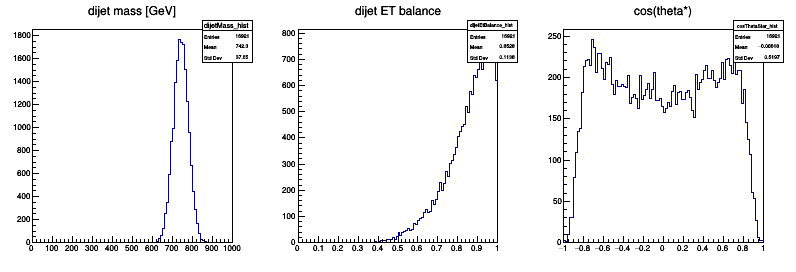

In [30]:
tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()